In [1]:
!date

Tue Nov 26 10:57:20 PST 2019


In [141]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import anndata
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
from kb_python.utils import import_matrix_as_anndata
from scipy.sparse import csr_matrix
from scipy.io import mmread, mmwrite
from matplotlib_venn import venn3
from sklearn.metrics import adjusted_rand_score
from scipy import stats
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches

plt.rcParams.update({'font.size': 18})

%config InlineBackend.figure_format = 'retina'

In [37]:
fsize = 20
gridalpha = 0.2

def knee_plot(mtx, ax=None, **kwargs):
    '''
        Makes knee plot.
        A: adata
        kwargs: [c = _lighten_color(B_color, 0.5), linewidth=2, alpha=1]
    '''
    ax = ax or plt.gca()

    ranked_umi = np.sort(mtx, axis=None)[::-1] # reversed
    ax.plot(ranked_umi, np.arange(len(ranked_umi)), **kwargs)
    return ax

def knee_plot_settings(mtx, ax=None):
    ax = ax or plt.gca()
    
    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_yscale("log", nonposy='clip')
    ax.set_xlabel('UMI counts',fontsize=fsize)
    ax.set_ylabel('Cumulative number of barcodes',fontsize=fsize)
    ax.set_title('',loc='center')
    #ax.set_title('A', fontweight='bold', fontsize = fsize, loc = 'left' )
    ax.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = gridalpha)


    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1])
    return ax

def plot_embedding(Y, comp=[0,1], labels=None, ax=None, plot_label=None, ax_label=None):
    x = Y[:,comp[0]]
    y = Y[:,comp[1]]

    ax = ax or plt.gca()

    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("{}1".format(ax_label))
    ax.set_ylabel("{}2".format(ax_label))
    if plot_label is None:
        plot_label = ""
        
    if ax_label is None:
        ax_label = ""

    if labels is not None:
        ax.scatter(x,y, c=labels, cmap="tab20b", label=plot_label)
        ax.legend(markerscale = 0)
        return ax
    ax.scatter(x,y, color="black")
    return ax

def plot_bulk(X, Y, xlabel=None, ylabel=None, ax=None):
    ax = ax or plt.gca()
    
    ax.set_xlim((10, 10**6))
    ax.set_ylim((10, 10**6))
    ax.set_xlabel(xlabel, fontsize=fsize)
    ax.set_ylabel(ylabel, fontsize=fsize)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_yscale("log", nonposy='clip')
    
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    
    
    ax.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = gridalpha)
    
    ax.scatter(X, Y, c="black", s=10, alpha=0.2)

    return ax

def _sparse_M_std(X):
    n = X.shape[0]
    return np.sqrt(n * X.multiply(X).sum(0) - np.multiply(X.sum(0), X.sum(0)))

def sparse_M_corr(X, Y):
    '''
        Computes Pearson correlation between X and Y (both in sparse format). Must be same shape.
        X: A_raw[common_obs.index].layers['log1p'] # raw
        Y: B_raw[common_obs.index].layers['log1p']# raw
        X: A.layers['log1p'] # filtered
        Y: B.layers['log1p'] # filtered
        Notes: I changed the axis in sum and shape, need to check if right
    '''
    X_std = _sparse_M_std(X)
    Y_std = _sparse_M_std(Y)
    XY_std = np.multiply(X_std, Y_std)
    n = X.shape[0]
    XY_cov = n*X.multiply(Y).sum(0) - np.multiply(X.sum(0), Y.sum(0))
    R = np.divide(XY_cov, XY_std)
    return np.squeeze(np.asarray(R))

def corr_plot(X, Y, xlabel=None, ax=None, leg=None):
    ax = ax or plt.gca()

    ax.set_xscale('log')
    ax.set_xlim(1,10**6)
    ax.set_ylim(0,1)
    ax.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = gridalpha)
    ax.set_xlabel(xlabel, fontsize = fsize)
    ax.set_ylabel('Pearson Correlation', fontsize = fsize)
    handles, labels = ax.get_legend_handles_labels()
    #ax.legend(handles[::-1], labels[::-1])

    ax.scatter(X, Y, c="black", s=10, alpha=0.2, label=leg[0]+" vs. "+leg[1])
    ax.legend()
    return ax

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar=0
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

# Load kite data

In [4]:
samples = 8
random_state = 42

In [6]:
raw = anndata.read_h5ad("/home/sina/projects/kite/cell-hashing/kite_out/counts_unfiltered/adata.h5ad")
raw.obs["counts"] = raw.X.sum(1)
raw.obs["num_nonzero"] = (raw.X>0).sum(1)
raw = raw[raw.obs["counts"]>0]

mtx = raw.X.todense()
raw.layers["norm"] = (mtx/raw.obs["counts"].values[:,None])*1000

In [10]:
kite = raw[raw.obs["counts"].nlargest(50000).index.values]
print(kite)

View of AnnData object with n_obs × n_vars = 50000 × 8 
    obs: 'counts', 'num_nonzero'
    layers: 'norm'


### Perform kmeans, PCA, TSNE, UMAP on kite

In [11]:
kmeans = KMeans(n_clusters=samples+1, random_state=random_state, init='k-means++')
pca = pca = PCA(n_components=2, random_state=random_state)
tsne = TSNE(random_state=random_state)
umap = UMAP(random_state=random_state)

In [13]:
%%time
kmeans.fit(kite.layers["norm"])
YY_pca = pca.fit_transform(kite.layers["norm"])
YY_tsne = tsne.fit_transform(kite.layers["norm"])
YY_umap = umap.fit_transform(kite.layers["norm"])

CPU times: user 48min 21s, sys: 46.1 s, total: 49min 7s
Wall time: 7min 40s


In [14]:
kite.obs["kmeans"] = kmeans.labels_

kite.obs["PCA0"] = YY_pca[:,0]
kite.obs["PCA1"] = YY_pca[:,1]

kite.obs["TSNE0"] = YY_tsne[:,0]
kite.obs["TSNE1"] = YY_tsne[:,1]

kite.obs["UMAP0"] = YY_umap[:,0]
kite.obs["UMAP1"] = YY_umap[:,1]


Trying to set attribute `.obs` of view, making a copy.


Save assignments

In [363]:
#adata.write_h5ad("./save/kite_adata.h5ad")

# Load cite-seq data v1.4.3

In [16]:
path = "/home/sina/projects/kite/cell-hashing/cite_seq_out_no_UMI_correction/umi_count/"
mtx = path + "matrix.mtx.gz"
mtx = mmread(mtx)
mmwrite(path + "matrix_T.mtx", mtx.T)

In [24]:
!gzip /home/sina/projects/kite/cell-hashing/cite_seq_out_no_UMI_correction/umi_count/matrix_T.mtx

In [25]:
gen = path + "features.tsv.gz"
bcs = path + "barcodes.tsv.gz"
mtx = path + "matrix_T.mtx.gz"

raw_cite = import_matrix_as_anndata(mtx, bcs, gen)
raw_cite = raw_cite[raw_cite.obs.sort_index().index.values]

In [28]:
raw_cite.var

""
gene_id
Donor_A-AGGACCATCCAA
Donor_B-ACATGTTACCGT
Donor_C-AGCTTACTATCC
Donor_D-TCGATAATGCGA
Donor_E-GAGGCTGAGCTA
Donor_F-GTGTGACGTATT
Donor_G-ACTGTCTAACGG
Donor_H-TATCACATCGGT
unmapped


In [29]:
raw_cite = raw_cite[:,0:8]

In [30]:
raw_cite.obs["counts"] = raw_cite.X.sum(1)

Trying to set attribute `.obs` of view, making a copy.


In [31]:
dense = raw_cite.X.todense()
mtx = dense/dense.sum(1)*1000
raw_cite.layers["norm"] = mtx

/home/sina/tools/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [32]:
cite = raw_cite[raw_cite.obs["counts"].nlargest(50000).index.values]
print(cite)

View of AnnData object with n_obs × n_vars = 50000 × 8 
    obs: 'counts'
    layers: 'norm'


## Perform kmeans, PCA, TSNE, UMAP on cite-seq

In [33]:
kmeans = KMeans(n_clusters=samples+1, random_state=random_state, init='k-means++')
pca = pca = PCA(n_components=2, random_state=random_state)
tsne = TSNE(random_state=random_state)
umap = UMAP(random_state=random_state)

In [34]:
%%time

kmeans.fit(cite.layers["norm"])
YY_pca = pca.fit_transform(cite.layers["norm"])
YY_tsne = tsne.fit_transform(cite.layers["norm"])
YY_umap = umap.fit_transform(cite.layers["norm"])

CPU times: user 48min 22s, sys: 40.3 s, total: 49min 3s
Wall time: 7min 51s


In [35]:
cite.obs["kmeans"] = kmeans.labels_

cite.obs["PCA0"] = YY_pca[:,0]
cite.obs["PCA1"] = YY_pca[:,1]

cite.obs["TSNE0"] = YY_tsne[:,0]
cite.obs["TSNE1"] = YY_tsne[:,1]

cite.obs["UMAP0"] = YY_umap[:,0]
cite.obs["UMAP1"] = YY_umap[:,1]


Trying to set attribute `.obs` of view, making a copy.


In [471]:
#new_hto.write_h5ad("./save/new_hto_adata.h5ad")

# Jaccard similarities between technologies

In [42]:
import itertools

In [49]:
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

In [50]:
jaccard_1 = np.zeros((samples + 1, samples + 1))

In [51]:
kite_clusters = np.sort(kite.obs.kmeans.unique())
cite_clusters = np.sort(cite.obs.kmeans.unique())

In [63]:
for i, j in list(itertools.product(kite_clusters, repeat=2)):
    a = kite[kite.obs.kmeans == i].obs.index.values
    b = cite[cite.obs.kmeans == j].obs.index.values
    
    jaccard_1[i, j] = jaccard_similarity(a, b) # kite vs cite

# Data Visualizations

In [67]:
all_bcs = [kite.obs.index.values, cite.obs.index.values]

common_bcs = np.sort(np.array(list(set.intersection(*map(set,all_bcs)))))

In [68]:
cmp_kite = kite[kite.obs.index.isin(common_bcs)].obs.index.values
cmp_cite = cite[cite.obs.index.isin(common_bcs)].obs.index.values

## Compare kmeans clustering on the common barcodes

1.0 is perfect

In [70]:
print("kite vs cite: ", adjusted_rand_score(cmp_kite, cmp_cite))

kite vs cite:  1.0


## Look at knee plot

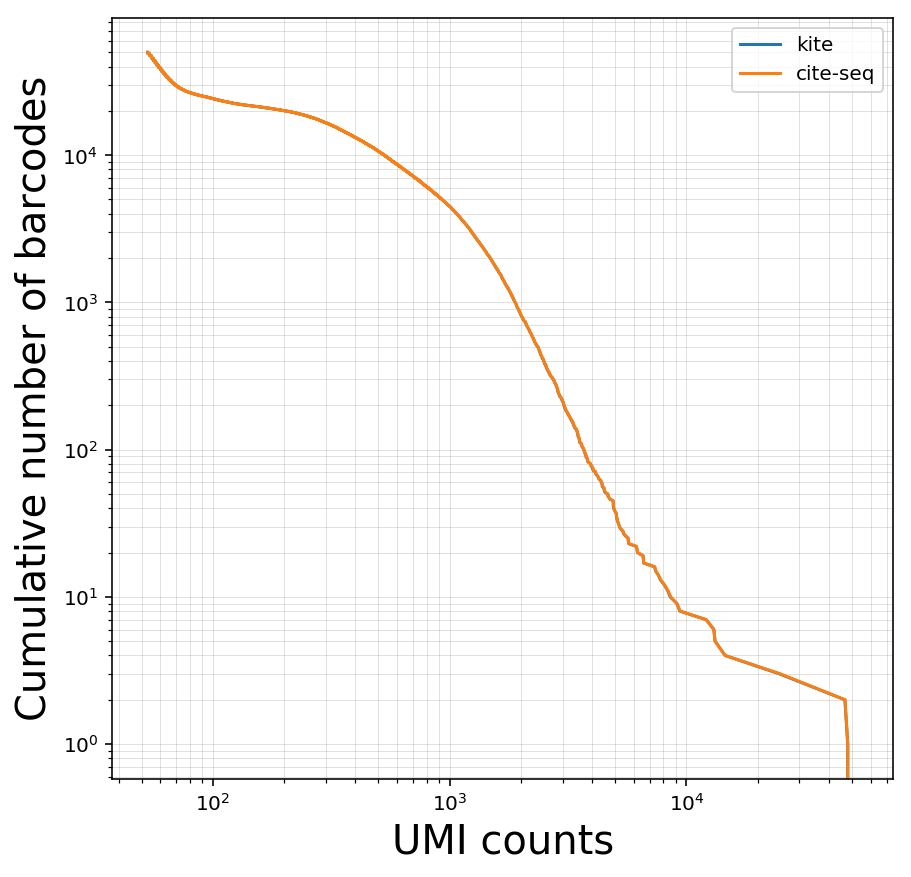

In [71]:
fig, ax = plt.subplots(figsize=(7, 7))

ax = knee_plot(kite.obs["counts"], ax, label="kite")
knee_plot_settings(kite.obs["counts"], ax)

ax = knee_plot(cite.obs["counts"], ax, label="cite-seq")
knee_plot_settings(cite.obs["counts"], ax)

plt.legend()

plt.show()

## PCA on normalized counts

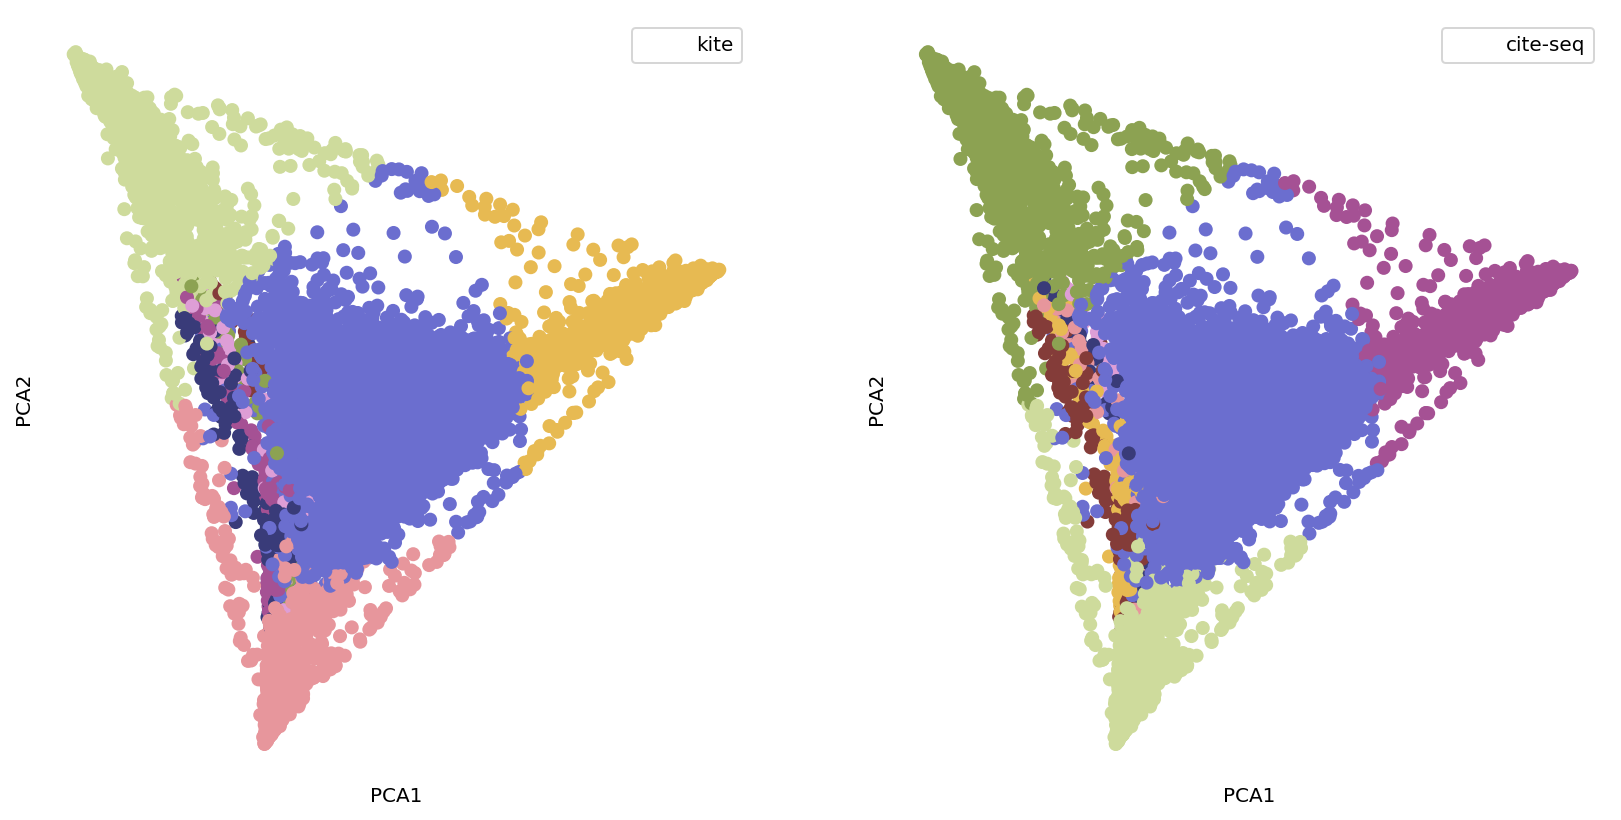

In [38]:
fig, ax = plt.subplots(figsize=(7*2, 7), ncols=2)

plot_embedding(kite.obs.loc[:,"PCA0":"PCA1"].values, ax=ax[0], labels=kite.obs.loc[:,"kmeans"].values, plot_label="kite", ax_label="PCA")
plot_embedding(cite.obs.loc[:,"PCA0":"PCA1"].values, ax=ax[1], labels=cite.obs.loc[:,"kmeans"].values, plot_label="cite-seq", ax_label="PCA")

plt.show()

## UMAP on normalized counts

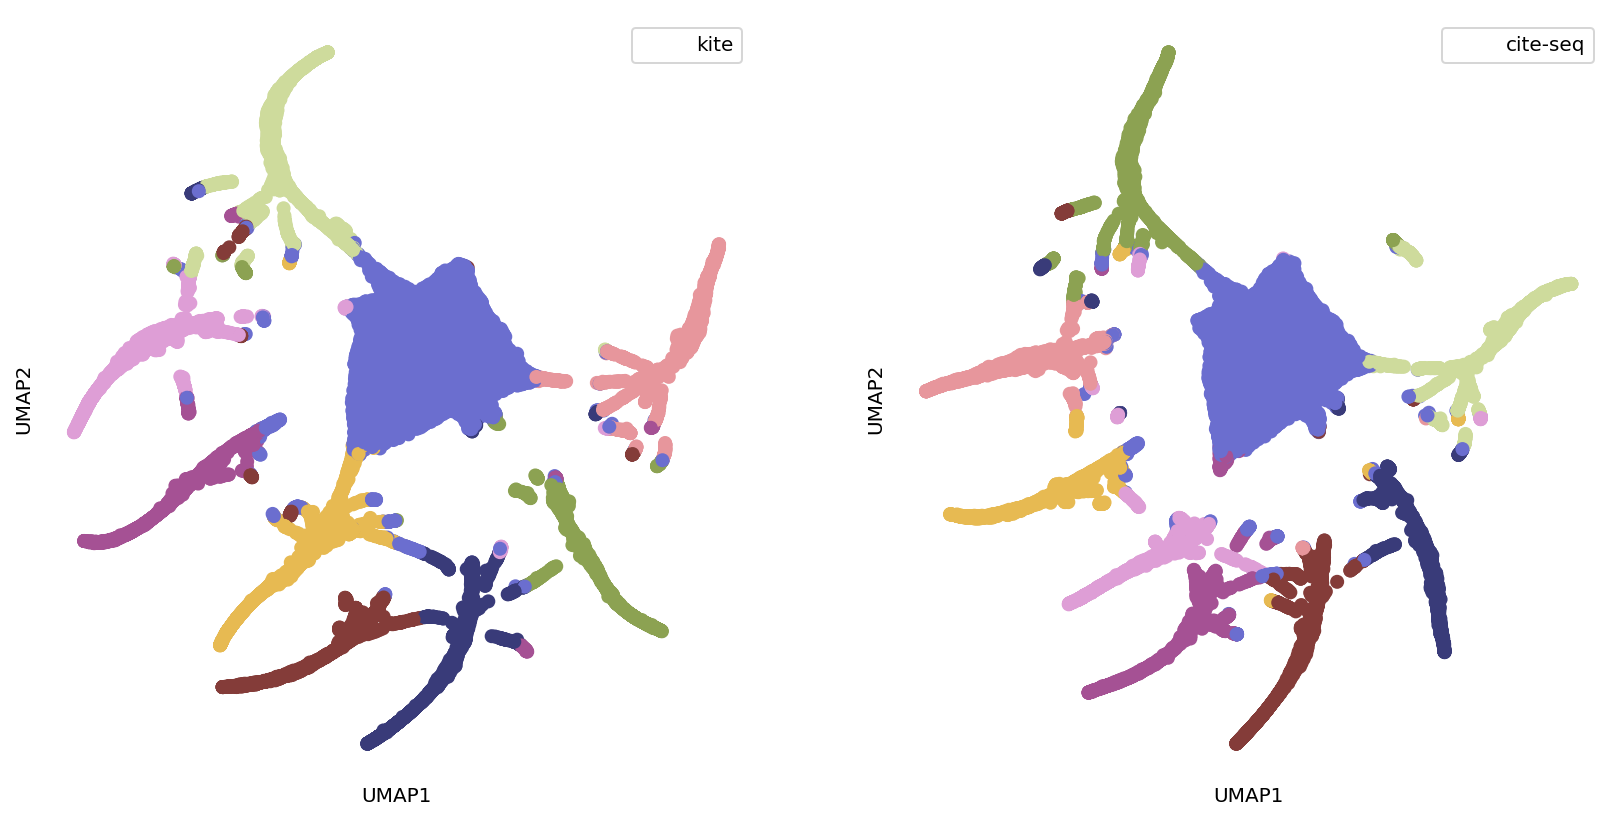

In [40]:
fig, ax = plt.subplots(figsize=(7*2, 7), ncols=2)

plot_embedding(kite.obs.loc[:,"UMAP0":"UMAP1"].values, ax=ax[0], labels=kite.obs.loc[:,"kmeans"].values, plot_label="kite", ax_label="UMAP")
plot_embedding(cite.obs.loc[:,"UMAP0":"UMAP1"].values, ax=ax[1], labels=cite.obs.loc[:,"kmeans"].values, plot_label="cite-seq", ax_label="UMAP")

plt.show()

## tSNE on normalized counts

In [473]:
# plot the number of counts

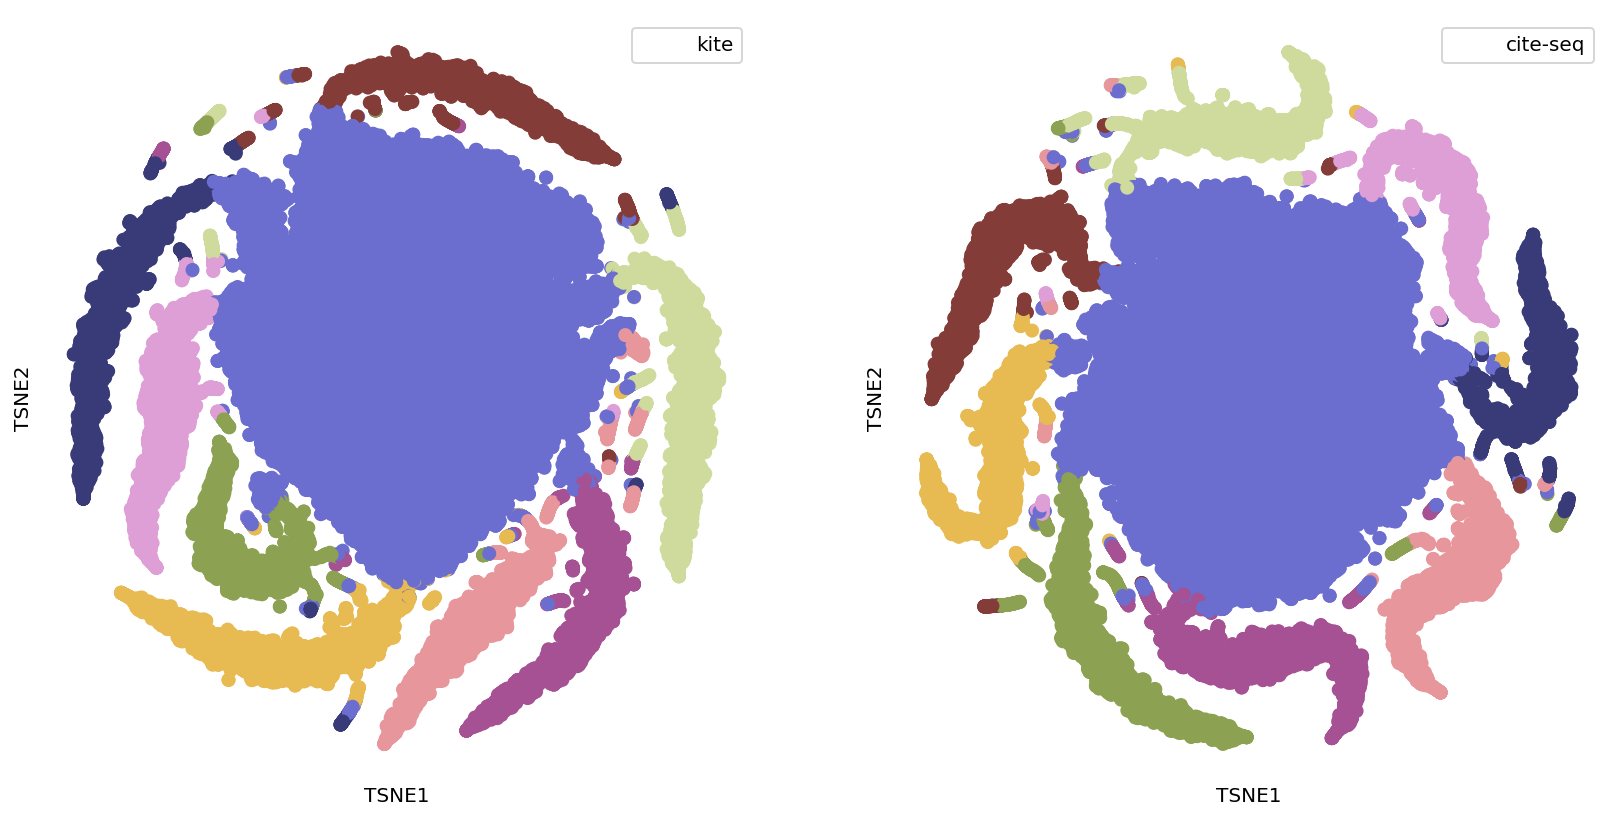

In [41]:
fig, ax = plt.subplots(figsize=(7*2, 7), ncols=2)

plot_embedding(kite.obs.loc[:,"TSNE0":"TSNE1"].values, ax=ax[0], labels=kite.obs.loc[:,"kmeans"].values, plot_label="kite", ax_label="TSNE")
plot_embedding(cite.obs.loc[:,"TSNE0":"TSNE1"].values, ax=ax[1], labels=cite.obs.loc[:,"kmeans"].values, plot_label="cite-seq", ax_label="TSNE")

plt.show()

## Each dot is a cell, sum counts and compare

In [72]:
kite_bulk = kite[kite.obs.index.isin(common_bcs)].obs.counts
cite_bulk = cite[cite.obs.index.isin(common_bcs)].obs.counts

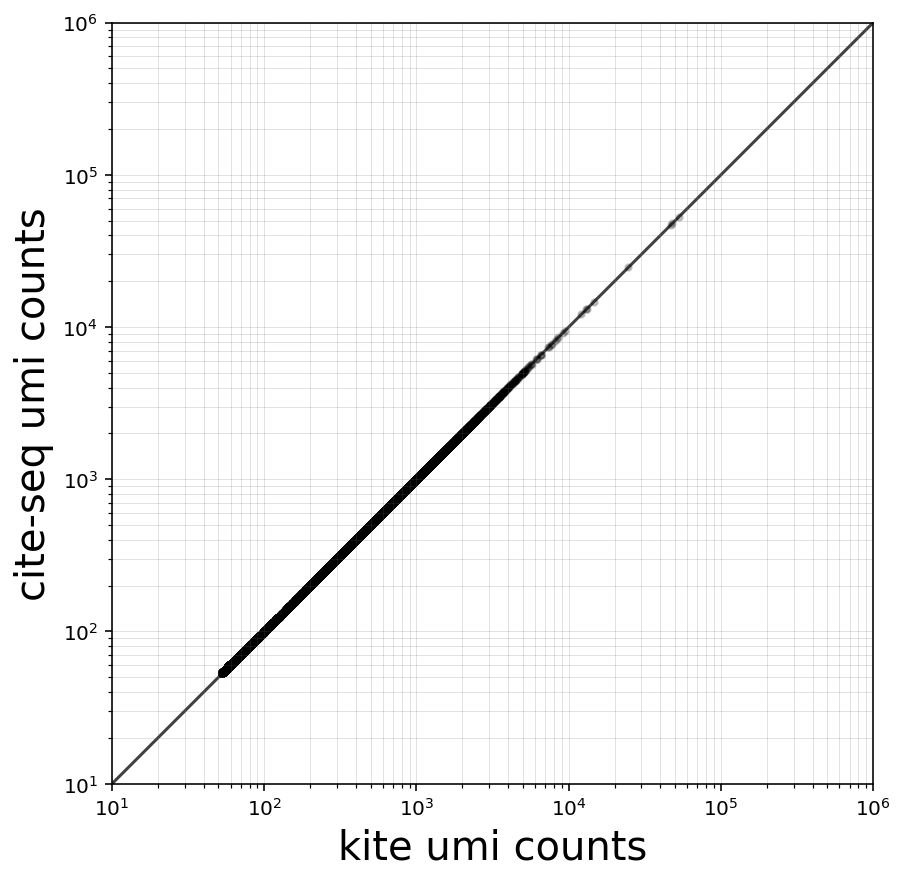

In [75]:
fig, ax = plt.subplots(figsize=(7*1, 7), ncols=1)

plot_bulk(kite_bulk, cite_bulk, xlabel="kite umi counts", ylabel="cite-seq umi counts", ax=ax)

plt.show()

In [76]:
print("r-squared values\n--")
slope, intercept, r_value, p_value, std_err = stats.linregress(kite_bulk, cite_bulk)
print("kite & cite-seq:\t", r_value**2)

r-squared values
--
kite & cite-seq:	 0.9999962462846305


## Pearson correlation on barcodes

In [77]:
corr_1 = sparse_M_corr(kite[common_bcs].X.T, cite[common_bcs].X.T)

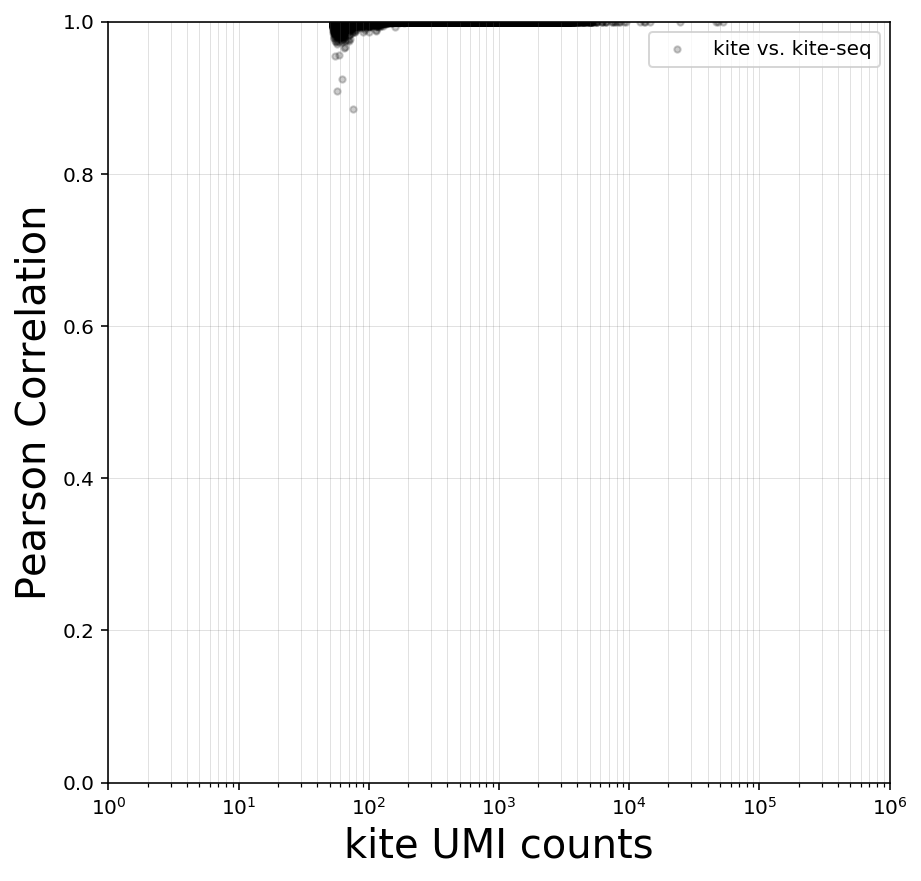

In [79]:
fig, ax = plt.subplots(figsize=(7*1, 7), ncols=1)

corr_plot(kite[common_bcs].obs["counts"].values, corr_1, ax=ax, xlabel="kite UMI counts", leg=["kite", "kite-seq"])

plt.legend()
plt.show()

# Clustering Analysis

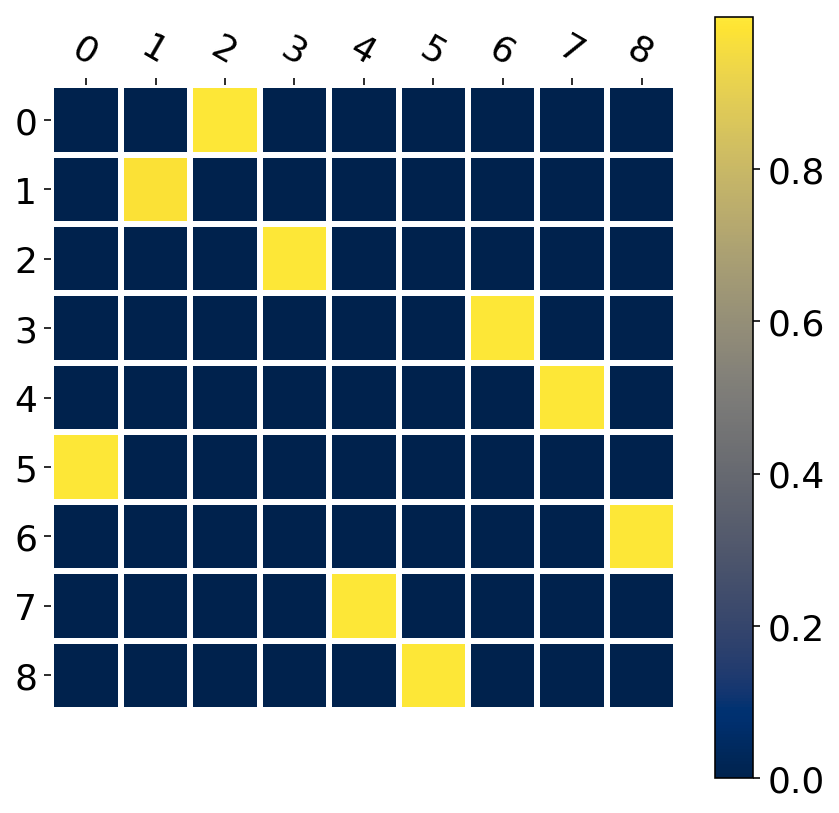

In [163]:
fig, ax = plt.subplots(figsize=(7*1,7), ncols=1)
heatmap(jaccard_1, kite_clusters, cite_clusters, ax=ax, cmap="cividis")
plt.show()

## Per cluster correlations

In [111]:
cluster_corr = []
cluster_size = []
for idx, cluster in enumerate(np.argmax(jaccard_1, axis=0)):
    a = kite[kite.obs.kmeans == idx]
    b = cite[cite.obs.kmeans == cluster]
    
    bcs = [a.obs.index.values, b.obs.index.values]
    
    common = np.sort(np.array(list(set.intersection(*map(set,bcs)))))
    
    cluster_corr.append(sparse_M_corr(a[common].X.T, b[common].X.T))
    
    cluster_size.append(common.shape[0])

In [118]:
variance = [i.var() for i in cluster_corr]

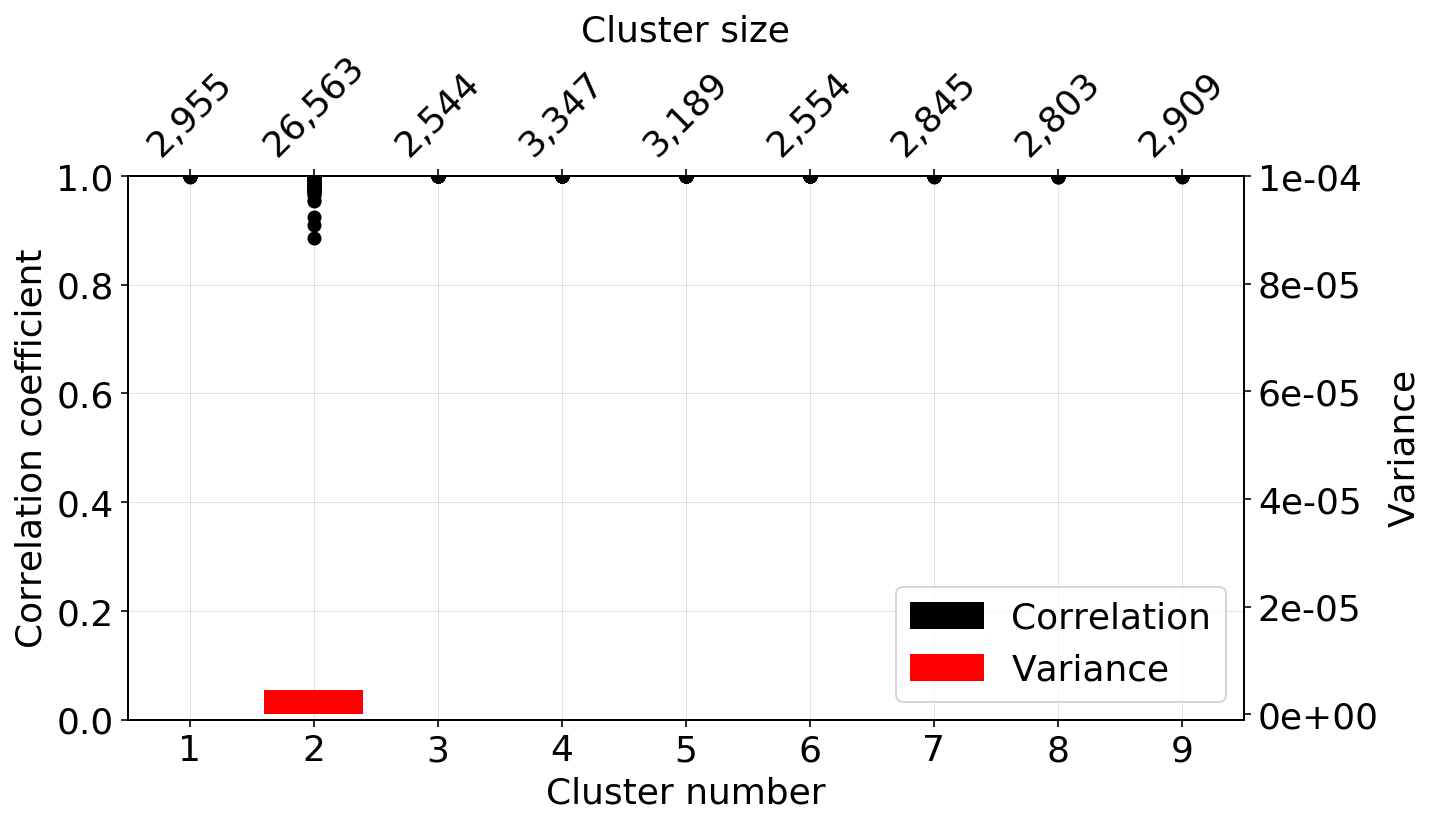

In [170]:
fig, ax = plt.subplots(figsize = (10, 5))
ax.boxplot(cluster_corr, sym='black')
ax.set_ylim(0,1)
ax.set_ylabel("Correlation coefficient")
ax.set_xlabel("Cluster number")
ax.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = 0.2)


new_tick_locations = np.arange(1, samples+2)
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(cluster_size)
ax2.set_xticklabels(['{:,}'.format(int(x)) for x in cluster_size])
ax2.xaxis.set_tick_params(rotation=45)



ax2.set_xlabel("Cluster size")

ax3 = ax.twinx()
ax3.bar(new_tick_locations, variance, color="red", linewidth=5)
ax3.set_ylim(-10**-6, 10**-4)
ax3.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0e'))
ax3.set_ylabel("Variance")

black_dot = mpatches.Patch(color='black', label='Correlation')
red_line = mpatches.Patch(color='red', label='Variance')
plt.legend(handles=[black_dot, red_line], loc="lower right")

plt.show()